In [3]:
pip install pyspark
sc.install_pypi_package("pandas==1.0.7")
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("seaborn", "https://pypi.org/simple")
##sc.install_pypi_package("sklearn", "https://github.com/scikit-learn/sklearn-pypi-package")
sc.install_pypi_package("scikit-learn")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=47b58f679cfc48b57422ccbf8c52d596f8654b8cb5d6bb2bb33e647e536da93b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
#Importing Libraries
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
#For visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [5]:
#Loading the dataset into Spark's Data frame
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CSVToDataFrame").getOrCreate()

local_path = "s3://bigproject1/Fraud_detection_system.csv"

spark_df = spark.read.csv(local_path, header=True, inferSchema=True)

spark_df.show()


+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [6]:
#Data pre-processing
selected_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]
data = spark_df.select(selected_cols)
data = data.dropna()
data = data.withColumn("label", lit(1.0).cast("double"))

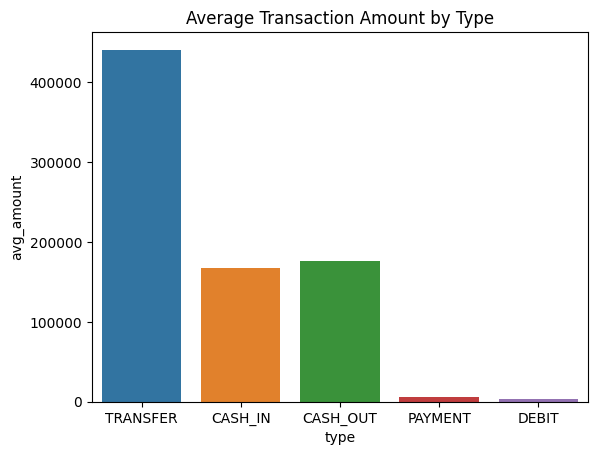

In [7]:
#Data Visualization to understand the relationship in between the variables.
from pyspark.sql import functions as F

type_vs_amount = spark_df.groupBy("type").agg(
    F.avg("amount").alias("avg_amount"),
    F.sum("amount").alias("total_amount")
).toPandas()
#after converting to pandas dataframe i have used bar chart to compare the values
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x='type', y='avg_amount', data=type_vs_amount)
plt.title('Average Transaction Amount by Type')
plt.show()
#Looks like transcations with "transfers" are more in number.

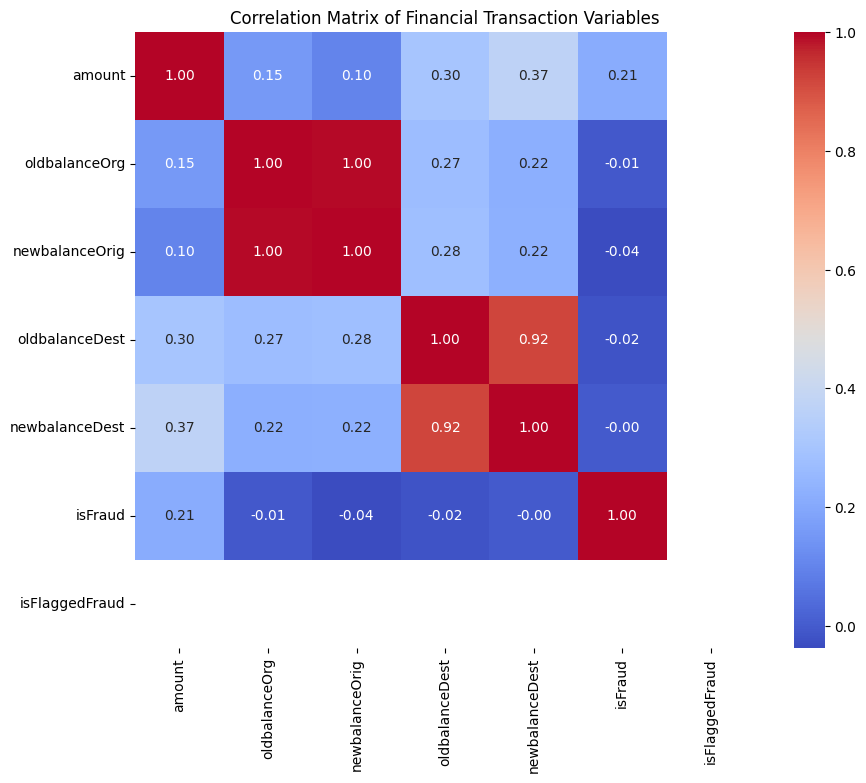

In [8]:
# To explore the correlation towards each variable with respective to the isfraud variable
from pyspark.sql.types import DoubleType
df = spark_df.withColumn("isFraud", spark_df["isFraud"].cast(DoubleType()))
df = spark_df.withColumn("isFlaggedFraud", spark_df["isFlaggedFraud"].cast(DoubleType()))
numeric_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud", "isFlaggedFraud"]
df_numeric = df.select(numeric_cols)
cm = df_numeric.toPandas().corr()
#using seaborn libraries for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Financial Transaction Variables")
plt.show()

In [9]:
#As per the correlation matrix suggests that amount variable has higher
#endency towards isfraud and looks like higher the amount, there is more chance of fradulent activities

In [10]:
#we cannot come to a conclusion based on correlation matrix,
#we need to combine all the features using random forest classifer

In [11]:
feature_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

In [12]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=100)
model = rf_classifier.fit(train_data)

In [13]:
# Import necessary libraries
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#Model Tuning

rf_classifier = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label")


grid_of_params = (ParamGridBuilder()
    .addGrid(rf_classifier.numTrees, [50, 100, 150])
    .addGrid(rf_classifier.maxDepth, [5, 10, 15])
    .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

model_cross_val = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=grid_of_params,
                          evaluator=evaluator,
                          numFolds=5)
cv_model = model_cross_val.fit(train_data)
best_rf_model = cv_model.bestModel
test_predictions = best_rf_model.transform(test_data)
test_auc = evaluator.evaluate(test_predictions)
print(f"Best Model AUC on Test Data: {test_auc}")
best_num_trees = best_rf_model.getNumTrees
best_max_depth = best_rf_model.getMaxDepth
print(f"Best Number of Trees: {best_num_trees}")
print(f"Best Max Depth: {best_max_depth}")


Best Model AUC on Test Data: 1.0
Best Number of Trees: 50
Best Max Depth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_ab3a7a920bec, numTrees=50, numClasses=2, numFeatures=5>


In [14]:
# Make predictions on the test data
predictions = model.transform(test_data)
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
area_under_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area under ROC: {area_under_roc}")

Area under ROC: 1.0


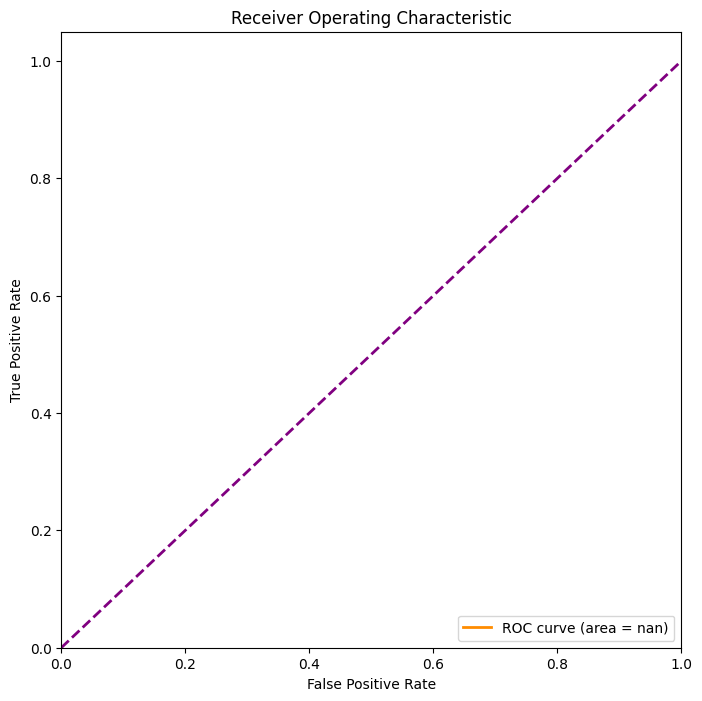

In [18]:

# dataframe conversion
pandas_df = predictions.select('label', 'probability').toPandas()
#probabilities selection
probabilities = pandas_df['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(pandas_df['label'], probabilities)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()